## Proyecto Final Batalla de los Vecindarios

## Table of contents
* [Introcucción: Definición del Problema](#Definición) 
* [Descripción de los Datos](#Datos)
* [Librerias y Dependencias](#Librerias)
* [Exploración de los Datos](#Análisis)
* [Variables Geográficas](#VariablesGeo)
* [Variables Telecomunicaciones](#VariablesTeleco)
* [Clustering](#Clustering)
* [Resultados](#conclusion)

### Definición del Problema Comercial
Después de la Pandema, se ha observado que muchos han empezado a moverse de 
las grandes ciudades a hacia ciudades mas pequeñas en busqueda de sitios mas tranquilos gracias a la posibilidad del trabajo virtual. 

Por eso un grupo de inversionistas quieren hacer un estudio en la Costa Atlántica Argentina para determinar la ciudad con mayor potencial para desarrollar en un proyecto inmobiliario con todos los servicios para el trabajo desde casa.

### Descripción de los Datos
Los datos necesarios para este analisis son:

**Coordenadas geograficas de la Costa Atlántica:**
Coordenadas geográficas de Buenos Aires obtenidos de la pagina Foursquare. 
https://es.foursquare.com/developers/projects

 Datos geográficos de las localidades balnearias de Argentina disponibles en el repositorio público de datos de la Republica Argentina disponible en el siguiente enlace:
https://datos.gob.ar/ar/dataset/jgm-servicio-normalizacion-datos-geograficos/archivo/jgm_8.12

**Localidades balnearias de la Costa Atlántica:**
Las ciudades balnearias mas importantes de la Costa Atlantica y una lista del top 10 por población según el censo del año 2016, ya que son las ciudades con mas infraestructura son tentativamente la mejor opcion para tener en cuenta en el lugar deseado para invertir, datos obtenidos de Wikipedia según el Censo 2016. https://es.wikipedia.org/wiki/Localidades_balnearias_del_mar_Argentino

**Acceso a Internet fijo por tecnología y Localidad:**
Detalle del acceso de Internet y velocidades promedio de Internet fijo por localidad proporcionadas por la ENACOM, ya que se busca localidades con buena infraestructura de servicios de Internet. Datos disponibles por el ente regularor de Telecomunicaciones de Argentina en el siguiente enlace: https://datosabiertos.enacom.gob.ar/dashboards/20000/acceso-a-internet/

Estos datos permitirán a los científicos de datos responder las preguntas de los inversores y determinar en que ciudades conviene desarrollar el proyecto. 



### Librerias y Dependencias
Ahora se importa todo lo necesario para hacer el análisis

In [391]:
import numpy as np  # librería para manejar datos vectorizados
import pandas as pd # librería para procesar datos como dataframes 

In [120]:
import matplotlib.pyplot as plt #librería para graficar
%matplotlib inline 

In [121]:
# librería para manejar archivos JSON 
import json 

#!conda install -c conda-forge geopy --yes # retirar el comentario de esta línea si no ha completado el laboratorio de la API de FourSquare 
from geopy.geocoders import Nominatim # convertir una dirección en valores de latitud y longitud

import requests # librería para manejar solicitudes
from pandas.io.json import json_normalize # librería para convertir un archivo json en un dataframe pandas

# Matplotlib y módulos asociados para graficar
import matplotlib.cm as cm
import matplotlib.colors as colors

# importar k-means desde la fase de agrupación
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

#!conda install -c conda-forge folium=0.5.0 --yes # retirar el comentario de esta línea si no ha completado el laboratorio de la API de FourSquare
import folium # librería para graficar mapas 

print('Libraries imported.')

Libraries imported.


### Exploración de las Ciudades en la Costa Atlántica Argentina
A continuación, se va a realizar una exploración de las ciudades en la Costa Atlantica y obtener su información geográfica para ver su ubicación y determinar sus características comerciales.

#### Obtención de los dataset

Inicialmente se descarga la información geográficas de las ciudades de la Costa Atlántica Argentina desde el repositorio público de datos de Argentina

In [926]:
import wget

url="https://infra.datos.gob.ar/catalog/modernizacion/dataset/7/distribution/7.29/download/localidades-censales.csv"
path="C:/Users/u605929/Documents/CURSOS/PYTHON/Ciencia de Datos Aplicada Programa Especializado/4. Capstone/Batalla de los Vecindarios/"
wget.download(url,path)


'C:/Users/u605929/Documents/CURSOS/PYTHON/Ciencia de Datos Aplicada Programa Especializado/4. Capstone/Batalla de los Vecindarios//localidades-censales (1).csv'

In [124]:
url_prov="https://infra.datos.gob.ar/catalog/modernizacion/dataset/7/distribution/7.7/download/provincias.csv"
wget.download(url_prov,path)

'C:/Users/u605929/Documents/CURSOS/PYTHON/Ciencia de Datos Aplicada Programa Especializado/4. Capstone//provincias (1).csv'

In [928]:
url_internet="http://api.datosabiertos.enacom.gob.ar/api/v2/datastreams/CONEC-AL-SERVI-DE-INTER/data.csv?auth_key=44a38fbffd39c9f7d84e8e7dd2e1d02f0950e611&download=1"
wget.download(url_internet,path)

In [337]:
localidades=pd.read_csv("localidades-censales.csv")
internet=pd.read_csv("ConectividadalserviciodeInternet.csv")

In [126]:
provincias=pd.read_csv(path+"provincias.csv")

#### Exploración de los Datos

Las Localidades en Argentina son:

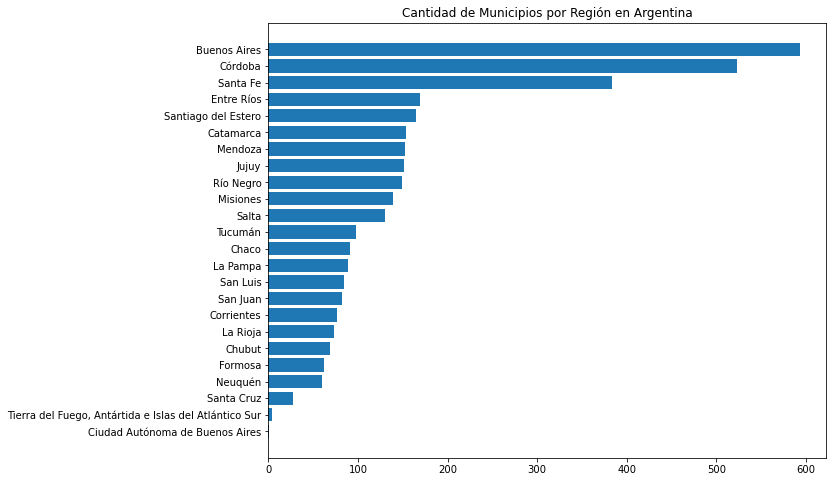

In [128]:
regiones=pd.DataFrame(localidades.groupby(["provincia_nombre"]).size(),columns=['municipios']).sort_values(by="municipios")

# Initialize a Figure and an Axes
fig, ax = plt.subplots()

# Fig size
fig.set_size_inches(10,8)

# Create horizontal bars
ax.barh(y=regiones.index, width=regiones.municipios);

# Add title
ax.set_title('Cantidad de Municipios por Región en Argentina');


El estudio se limita a las provincias con ciudades sobre la Costa Atlantica, estas son Buenos Aires, Rio Negro, Chubut, Santa Cruz y Tierra del Fuego. Por medio de la libreria folium se muestran las localidades seleccionadas en un mapa.

In [129]:
regiones["Provincias"]=regiones.index

geo_prov=regiones.merge(provincias,left_on="Provincias",right_on="nombre")

In [132]:
#url_map="https://dnsg.ign.gob.ar/apps/api/v1/capas-sig/Geodesia+y+demarcaci%C3%B3n/L%C3%ADmites/provincia/json"
url_map="https://infra.datos.gob.ar/catalog/modernizacion/dataset/7/distribution/7.12/download/provincias.geojson"
filename=wget.download(url_map)

print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [134]:
costa_atlan=geo_prov.loc[[1,2,5,15,23]]
costa_atlan=costa_atlan.drop(["categoria","nombre","fuente","id","iso_id","nombre_completo","Provincias"],axis=1)

In [135]:
costa_atlan.reset_index(drop=True,inplace=True)
costa_atlan.rename(columns={"iso_nombre": "Provincia", "B": "c"},inplace=True)

In [136]:
address = 'Argentina'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Argentina are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Buenos Aires are -34.9964963, -64.9672817.


In [137]:
# crear un mapa de Manhattan usando los valores de latitud y longitud
map_costa = folium.Map(location=[latitude, longitude], zoom_start=4)

# añadir los marcadores al mapa
for lat, lng, label in zip(costa_atlan['centroide_lat'], costa_atlan['centroide_lon'], costa_atlan['Provincia']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_costa)  
    
map_costa

De estas 4 provincias, se seleccionarán las localidades con acceso al mar e infraestructura para disfrutar de las playas, recibir nuevos pobladores.

In [291]:
costa_atlan

,municipios,centroide_lat,centroide_lon,Provincia
0,4,-82.521518,-50.742749,Tierra del Fuego
1,27,-48.815485,-69.955762,Santa Cruz
2,69,-43.788623,-68.526759,Chubut
3,149,-40.405796,-67.229330,Río Negro
4,593,-36.676942,-60.558832,Buenos Aires


In [290]:
#localidades con acceso al mar fuente Wikipedia
loc_costa=pd.read_csv("Localidades_Costa.csv", encoding='latin-1')

#Se limpia los datos 
costa_limpio=pd.DataFrame(data=loc_costa["Localidades_Costa"].str.strip())

#Se hace merge con el repositorio de localidades
costa_merge=localidades.merge(costa_limpio,left_on='nombre',right_on='Localidades_Costa')

print("Localidades de la Costa",costa_limpio.shape)
print("Merge con el Repositorio",costa_merge.shape)

Localidades de la Costa (65, 1)
Merge con el Repositorio (45, 14)


In [308]:
#Se limpia las localidades que pueden tener nombre repetido y esten por fuera de las localidades en análisis.
costa_data=costa_merge[(costa_merge["provincia_nombre"]=="Buenos Aires")|
            (costa_merge["provincia_nombre"]=="Chubut")|
            (costa_merge["provincia_nombre"]=="Santa Cruz")|
            (costa_merge["provincia_nombre"]=="Río Negro")|
            (costa_merge["provincia_nombre"]=="Tierra del Fuego, Antártida e Islas del Atlántico Sur")
            ]

### Variables Geográficas

#### Obtención de variables por medio del servicio de Foursquare
A continuación vamos a empezar a utilizar el API de FourSquare para explorar las localidades y segmentarlos, por medio de una función que los explore todos.

In [309]:
CLIENT_ID = 'LM5HN3042JGPC50VLXUT2XG4L1Z4BN3DY1S5MBA5ANSVO54V' # su ID de Foursquare
CLIENT_SECRET = 'YCBLJNJX2WJMP0CKANFLTPXGSAQIARRGUKPB5BRROGAWPJO3' # Secreto de Foursquare
VERSION = '20180605' # versión de la API de Foursquare
LIMIT = 100 # Un valor límite para la API de Foursquare

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LM5HN3042JGPC50VLXUT2XG4L1Z4BN3DY1S5MBA5ANSVO54V
CLIENT_SECRET:YCBLJNJX2WJMP0CKANFLTPXGSAQIARRGUKPB5BRROGAWPJO3


In [310]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # crear la URL de solicitud de API
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # solicitud GET
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # regresa solo información relevante de cada sitio cercano
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

De la función se obtienen todas las calles de las ciudades de la costa

In [311]:
cos_venues = getNearbyVenues(names=costa_data['nombre'],
                                   latitudes=costa_data['centroide_lat'],
                                   longitudes=costa_data['centroide_lon']
                                  )

Bahía Blanca
General Daniel Cerri
Balneario Pehuen Co
Oriente
Mar del Sur
Miramar
Chapadmalal
Mar del Plata
Las Toninas
Mar de Ajó - San Bernardo
San Clemente del Tuyú
Santa Teresita - Mar del Tuyú
Arenas Verdes
Mar Chiquita
Mar de Cobo
Santa Clara del Mar
Monte Hermoso
Necochea - Quequén
Bahía San Blas
Pinamar
Balneario San Cayetano
Balneario Orense
Claromecó
Reta
Mar Azul
Villa Gesell
Puerto Madryn
Comodoro Rivadavia
Rada Tilly
Playa Magagna
Playa Unión
El Cóndor
Las Grutas
Playas Doradas
Playas Doradas
Puerto San Antonio Este
San Antonio Oeste
Río Grande
Caleta Olivia


In [313]:
cos_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Arenas Verdes,2,2,2,2,2,2
Bahía Blanca,12,12,12,12,12,12
Balneario Orense,2,2,2,2,2,2
Balneario Pehuen Co,2,2,2,2,2,2
Balneario San Cayetano,1,1,1,1,1,1
Caleta Olivia,7,7,7,7,7,7
Chapadmalal,5,5,5,5,5,5
Claromecó,5,5,5,5,5,5
Comodoro Rivadavia,5,5,5,5,5,5


In [314]:
print('Hay {} categorias únicas.'.format(len(cos_venues['Venue Category'].unique())))

Hay 75 categorias únicas.


#### Normalización de Variables

Ahora se prepara el dataset para poder aplicar el modelo de segmentación. Para esto las variables categóricas se pasan a Dummies (1 o 0) y las numéricas se llevan al mismo rango. A este proceso se llama normalización de variables o codificación.

In [1064]:
# codificación
costa_onehot = pd.get_dummies(cos_venues[['Venue Category']], prefix="", prefix_sep="")

# añadir la columna de barrio de regreso al dataframe
costa_onehot['Neighbourhood'] = cos_venues['Neighbourhood'] 

# mover la columna de barrio a la primer columna
fixed_columns = [costa_onehot.columns[-1]] + list(costa_onehot.columns[:-1])
costa_onehot = costa_onehot[fixed_columns]

#Agrupación por el promedio
costa_grouped = costa_onehot.groupby('Neighbourhood').mean().reset_index()

In [316]:

costa_grouped.head()

,Neighbourhood,Arcade,Argentinian Restaurant,Art Gallery,BBQ Joint,Bakery,Bar,Beach,Bed & Breakfast,Bistro,...,Resort,Restaurant,Salad Place,Seafood Restaurant,Shopping Mall,Skating Rink,Snack Place,Supermarket,Surf Spot,Theater
0,Arenas Verdes,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,...,0.0,0.5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,Bahía Blanca,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0
2,Balneario Orense,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,...,0.0,0.5,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,Balneario Pehuen Co,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,Balneario San Cayetano,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


Ahora se van a seleccionar los 3 sitios mas comunes de cada localidad. Primero por medio de una función se ordenan los sitios en orden descendente.

In [317]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Se genera el nuevo dataframe y con los 3 sitios mas populares de cada localidad.

In [1054]:
num_top_venues = 3

indicators = ['st', 'nd', 'rd']

# crear las columnas acorde al numero de sitios populares
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# crear un nuevo dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = costa_grouped['Neighbourhood']

for ind in np.arange(costa_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(costa_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Arenas Verdes,Restaurant,Beach,Lake
1,Bahía Blanca,Café,Gastropub,Burger Joint
2,Balneario Orense,Restaurant,Beach,Lake
3,Balneario Pehuen Co,Argentinian Restaurant,Campground,Golf Course
4,Balneario San Cayetano,Beach,Arcade,Lake


### Variables de Telecomunicaciones

A las variables encontradas de categoría de sitios populares, se van a sumar las relacionadas con los servicios de telecomunicaciones. Que detalla las tecnologías disponibles en cada localidad para acceder al servicio de Internet fijo y móvil.



In [945]:
##Sumar variables de Internet
acceso=internet.drop(["Partido","link","Latitud","Longitud"],axis=1)

#Se limpia las localidades que pueden tener nombre repetido y esten por fuera de las localidades en análisis.
int_var=acceso[(acceso["Provincia"]=="BUENOS AIRES")|
            (acceso["Provincia"]=="CHUBUT")|
            (acceso["Provincia"]=="SANTA CRUZ")|
            (acceso["Provincia"]=="RIO NEGRO")|
            (acceso["Provincia"]=="TIERRA DEL FUEGO")
            ]

In [972]:
#Se hace un merge para trabajar solo con las localidades en estudio
variables_data=costa_grouped[["Neighbourhood"]].merge(int_var,how="left",left_on="Neighbourhood",right_on="Localidad")

In [975]:
variables_data.columns

Index(['Neighbourhood', 'Provincia', 'Localidad', 'Poblacion', 'ADSL',
       'CABLEMODEM', 'DIALUP', 'FIBRAOPTICA', 'SATELITAL', 'WIRELESS',
       'TELEFONIAFIJA', '3G', '4G'],
      dtype='object')

In [998]:
variables_data.head()

,Neighbourhood,Provincia,Localidad,Poblacion,ADSL,CABLEMODEM,DIALUP,FIBRAOPTICA,SATELITAL,WIRELESS,TELEFONIAFIJA,3G,4G
0,Arenas Verdes,BUENOS AIRES,Arenas Verdes,12,--,--,--,--,--,SI,--,SI,SI
1,Bahía Blanca,BUENOS AIRES,Bahía Blanca,291327,SI,SI,SI,SI,SI,SI,SI,SI,SI
2,Balneario Orense,BUENOS AIRES,Balneario Orense,77,--,--,--,--,--,--,--,SI,SI
3,Balneario Pehuen Co,BUENOS AIRES,Balneario Pehuen Co,681,--,--,--,--,SI,--,SI,SI,SI
4,Balneario San Cayetano,BUENOS AIRES,Balneario San Cayetano,46,--,--,--,--,--,SI,SI,--,--


De estas 4 provincias, se seleccionarán las localidades con acceso al mar e infraestructura para disfrutar de las playas, recibir nuevos pobladores.

Se deben normalizar las variables de conexión de Internet para que sean intrepretadas correctamente por el modelo. Para esto se convierte las variables alfanumericas correspondientes a los tipos de conexión a 0 y 1.

In [976]:
# example of a ordinal encoding
from numpy import asarray
from sklearn.preprocessing import OrdinalEncoder
#define data
data = variables_data[['ADSL','CABLEMODEM','DIALUP','FIBRAOPTICA','SATELITAL','WIRELESS', 'TELEFONIAFIJA','3G','4G']]
# define ordinal encoding
encoder = OrdinalEncoder()
# transform data
result = encoder.fit_transform(data)

Convertir de nuevo a un dataframe y unirlo a las variables geográficas ya normalizadas

In [988]:
#Convertir a un dataframe
internet_grouped=pd.DataFrame(data=result,columns=[data.columns]).reset_index(drop=True)

#Concatenar con las variables geograficas
var_grouped=pd.concat([costa_grouped,internet_grouped], axis=1)


In [1038]:
internet_grouped.describe()

,ADSL,CABLEMODEM,DIALUP,FIBRAOPTICA,SATELITAL,WIRELESS,TELEFONIAFIJA,3G,4G
count,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,0.647059,0.441176,0.588235,0.500000,0.411765,0.705882,0.852941,0.823529,0.823529
std,0.485071,0.503995,0.499554,0.507519,0.499554,0.462497,0.359491,0.386953,0.386953
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
50%,1.000000,0.000000,1.000000,0.500000,0.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Se agrupan los tipos de Acceso, en tres grupos:
1. **Red Movil:** Accesos de las Red móvil 2G y 3G
2. **Red Banda Ancha:** Accesos ADSL, Cablemódem y Fibra
3. **Red Banda Angosta:** Satelital, DialUp y Wireless
4. **Teléfono Fijo:** Si tiene servicio de telefonia fija

In [1085]:
#Seleccion de Columnas con la información por tipo de red de acceso
internet_data=var_grouped.loc[:,var_grouped.columns[[0] +list(range(76, var_grouped.shape[1]))]]

#Argupaciones
internet_data["Red_Movil"]=np.where(internet_data.iloc[:,8]+internet_data.iloc[:,9]>0,"SI","NO")
internet_data["Red_BandaAncha"]=np.where(internet_data.iloc[:,1]+internet_data.iloc[:,2]+internet_data.iloc[:,4]>0,"SI","NO")
internet_data["Red_BandaAngosta"]=np.where(internet_data.iloc[:,3]+internet_data.iloc[:,5]+internet_data.iloc[:,6]>0,"SI","NO")
internet_data["Telefono_Fijo"]=np.where(internet_data.iloc[:,7]>0,"SI","NO")

#Se dejan solo las columnas agrupadas y se trae la informeación de Población
acceso_data=internet_data.loc[:,internet_data.columns[[0] + list(range(10,internet_data.shape[1]))]]
acceso_data.insert(1,'Poblacion', variables_data["Poblacion"])
acceso_data.head()

,Neighbourhood,Poblacion,Red_Movil,Red_BandaAncha,Red_BandaAngosta,Telefono_Fijo
0,Arenas Verdes,12,SI,NO,SI,NO
1,Bahía Blanca,291327,SI,SI,SI,SI
2,Balneario Orense,77,SI,NO,NO,NO
3,Balneario Pehuen Co,681,SI,NO,SI,SI
4,Balneario San Cayetano,46,NO,NO,SI,SI


Una vez seleccionadas las variables, se aplicará un modelo de clustering.

### Modelamiento  Clustering
Para el análisis de agrupamiento, se aplicará el modelo k-means. Inicialmente por medio de la curva del codo **(Elbow Curve)** se elige el valor de K

In [1049]:
#Variables para el modelo sin el campo Neighbourhood
costa_grouped_clustering = var_grouped.drop('Neighbourhood', 1)

C:\Users\u605929\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


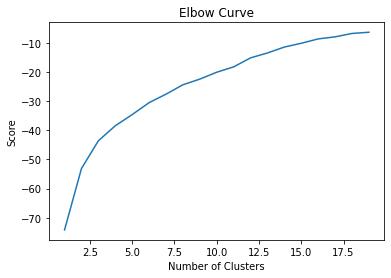

In [1050]:
#Curva del Codo
X=costa_grouped_clustering
Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

A partir de la gráfica anterior, se elige como mejor valor para **k=3**

In [1051]:
# establecer el número de agrupaciones
kclusters = 3

# ejecutar k-means
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(costa_grouped_clustering)

# revisar las etiquetas de las agrupaciones generadas para cada fila del dataframe
kmeans.labels_[0:10] 

array([2, 1, 2, 2, 0, 1, 1, 0, 1, 2])

Generemos un nuevo dataframe que incluya la agrupación asi como los 3 sitios mas populares de cada localidad.

In [1086]:
costa_localidades=costa_data[["Localidades_Costa","provincia_nombre","centroide_lat","centroide_lon"]].merge(acceso_data,left_on='Localidades_Costa', right_on='Neighbourhood')
costa_localidades=costa_localidades.drop("Neighbourhood",axis=1)
costa_localidades.head()

,Localidades_Costa,provincia_nombre,centroide_lat,centroide_lon,Poblacion,Red_Movil,Red_BandaAncha,Red_BandaAngosta,Telefono_Fijo
0,Bahía Blanca,Buenos Aires,-38.713805,-62.265960,291327,SI,SI,SI,SI
1,Balneario Pehuen Co,Buenos Aires,-38.996196,-61.547199,681,SI,NO,SI,SI
2,Mar del Sur,Buenos Aires,-38.344688,-57.992039,453,SI,NO,SI,SI
3,Miramar,Buenos Aires,-38.270743,-57.840471,29433,SI,SI,SI,SI
4,Chapadmalal,Buenos Aires,-38.175778,-57.651339,4112,SI,SI,SI,SI


In [1087]:
# añadir etiquetas
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

# juntar costa_grouped con costa_data 
costa_merged = costa_localidades.merge(neighborhoods_venues_sorted,left_on='Localidades_Costa', right_on='Neighbourhood')

costa_merged.head() # revisar las ultimas columnas

,Localidades_Costa,provincia_nombre,centroide_lat,centroide_lon,Poblacion,Red_Movil,Red_BandaAncha,Red_BandaAngosta,Telefono_Fijo,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,Bahía Blanca,Buenos Aires,-38.713805,-62.265960,291327,SI,SI,SI,SI,1,Bahía Blanca,Café,Gastropub,Burger Joint
1,Balneario Pehuen Co,Buenos Aires,-38.996196,-61.547199,681,SI,NO,SI,SI,2,Balneario Pehuen Co,Argentinian Restaurant,Campground,Golf Course
2,Mar del Sur,Buenos Aires,-38.344688,-57.992039,453,SI,NO,SI,SI,2,Mar del Sur,Breakfast Spot,Hotel,Eastern European Restaurant
3,Miramar,Buenos Aires,-38.270743,-57.840471,29433,SI,SI,SI,SI,1,Miramar,Café,Breakfast Spot,Italian Restaurant
4,Chapadmalal,Buenos Aires,-38.175778,-57.651339,4112,SI,SI,SI,SI,1,Chapadmalal,Resort,Beach,Italian Restaurant


Finalmente visualicemos las agrupaciones resultantes

In [1056]:
# crear mapa
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# establecer el esquema de color para las agrupaciones
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# añadir marcadores al mapa
markers_colors = []
for lat, lon, poi, cluster in zip(costa_merged['centroide_lat'], costa_merged['centroide_lon'], costa_merged['Localidades_Costa'], costa_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=10,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Análisis de los Resultados 
Ahora se hace un análisis de las agrupaciones se determina las categorias del sitio que distingue a cada agrupación.

#### Agrupación 1

In [1092]:
costa_merged.loc[costa_merged['Cluster Labels'] == 0, costa_merged.columns[[1] + list(range(4, costa_merged.shape[1]))]].sort_values("Poblacion",ascending=False)

,provincia_nombre,Poblacion,Red_Movil,Red_BandaAncha,Red_BandaAngosta,Telefono_Fijo,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
13,Buenos Aires,7713,NO,SI,SI,NO,0,Santa Clara del Mar,Art Gallery,New American Restaurant,Beach
19,Buenos Aires,2081,NO,SI,SI,SI,0,Claromecó,Restaurant,Bakery,Beach
30,Río Negro,381,NO,SI,SI,SI,0,Puerto San Antonio Este,Argentinian Restaurant,Bistro,Restaurant
26,Chubut,76,NO,NO,SI,NO,0,Playa Magagna,Beach,Arcade,Lake
17,Buenos Aires,46,NO,NO,SI,SI,0,Balneario San Cayetano,Beach,Arcade,Lake


#### Agrupación 2

In [1094]:
costa_merged.loc[costa_merged['Cluster Labels'] == 1, costa_merged.columns[[1] + list(range(4, costa_merged.shape[1]))]].sort_values("Poblacion",ascending=False)

,provincia_nombre,Poblacion,Red_Movil,Red_BandaAncha,Red_BandaAngosta,Telefono_Fijo,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
5,Buenos Aires,560913,SI,SI,SI,SI,1,Mar del Plata,Café,Theater,Restaurant
0,Buenos Aires,291327,SI,SI,SI,SI,1,Bahía Blanca,Café,Gastropub,Burger Joint
24,Chubut,175196,SI,SI,SI,SI,1,Comodoro Rivadavia,Gift Shop,Supermarket,Food & Drink Shop
15,Buenos Aires,84784,SI,SI,SI,SI,1,Necochea - Quequén,Café,Italian Restaurant,Burger Joint
23,Chubut,81315,SI,SI,SI,SI,1,Puerto Madryn,Gym Pool,Arcade,Lottery Retailer
32,"Tierra del Fuego, Antártida e Islas del Atlánt...",66475,SI,SI,SI,SI,1,Río Grande,Gym,Furniture / Home Store,Gym / Fitness Center
33,Santa Cruz,51733,SI,SI,SI,NO,1,Caleta Olivia,Candy Store,Pub,Park
3,Buenos Aires,29433,SI,SI,SI,SI,1,Miramar,Café,Breakfast Spot,Italian Restaurant
7,Buenos Aires,28466,SI,SI,SI,SI,1,Mar de Ajó - San Bernardo,Café,Argentinian Restaurant,Pizza Place
16,Buenos Aires,25397,SI,SI,SI,SI,1,Pinamar,Beach,Resort,Golf Course


#### Agrupación 3

In [1095]:
costa_merged.loc[costa_merged['Cluster Labels'] == 2, costa_merged.columns[[1] + list(range(4, costa_merged.shape[1]))]].sort_values("Poblacion",ascending=False)

,provincia_nombre,Poblacion,Red_Movil,Red_BandaAncha,Red_BandaAngosta,Telefono_Fijo,Cluster Labels,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
22,Buenos Aires,29593,SI,SI,NO,SI,2,Villa Gesell,German Restaurant,BBQ Joint,Supermarket
14,Buenos Aires,6351,SI,SI,NO,SI,2,Monte Hermoso,Argentinian Restaurant,Bakery,Fast Food Restaurant
29,Río Negro,4807,SI,SI,SI,SI,2,Las Grutas,Beach,Argentinian Restaurant,Resort
21,Buenos Aires,1797,SI,NO,NO,SI,2,Mar Azul,German Restaurant,Bakery,Seafood Restaurant
12,Buenos Aires,760,NO,NO,SI,SI,2,Mar de Cobo,Plaza,Market,Arcade
28,Río Negro,746,SI,NO,SI,SI,2,El Cóndor,Argentinian Restaurant,Lake,New American Restaurant
1,Buenos Aires,681,SI,NO,SI,SI,2,Balneario Pehuen Co,Argentinian Restaurant,Campground,Golf Course
20,Buenos Aires,495,SI,NO,SI,SI,2,Reta,Argentinian Restaurant,Supermarket,Beach
11,Buenos Aires,487,SI,NO,SI,SI,2,Mar Chiquita,Restaurant,Diner,Lake
2,Buenos Aires,453,SI,NO,SI,SI,2,Mar del Sur,Breakfast Spot,Hotel,Eastern European Restaurant


>Hecho por: **Natalia Clivio** [Linkedin](https://www.linkedin.com/in/natalia-a-clivio-velilla-650a1613/). 

>Para el proyecto final de Capstone del Curso Capstone

>Especialización de IBM - *Ciencia de Datos Aplicada*
>
>*Argentina 2021*